In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

In [3]:
!pip install -q torchinfo
from torchinfo import summary

In [4]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 4036 (delta 1069), reused 1087 (delta 998), pack-reused 2812
Receiving objects: 100% (4036/4036), 650.87 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (2362/2362), done.
Updating files: 100% (248/248), done.


In [5]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#1. Get Data

In [6]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f'{image_path} directory exists, skipping re-download.')
else:
  print(f'Did not find {image_path} downloading it...')
  image_path.mkdir(parents = True, exist_ok = True)

  # Download the pizza, steak and sushi data
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading Pizza, steak and sushi data......')
    f.write(requests.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza steak sushi data.......')
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')

Did not find data/pizza_steak_sushi downloading it...
Unzipping pizza steak sushi data.......


In [7]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transforms for our `torchvision.models` (Manual_Creation)

In [8]:
from torchvision import transforms

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing the image to 224, 224 (height x width)
    transforms.ToTensor(), # getting values between [0,1]
    normalize # making sure images have the same distribution as the model ImageNet
])

In [9]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7da5b1959030>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transforms for `torchvision.models` (Auto creation)

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'DEFAULT' = Best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7da4dbfeb220>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

In [13]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b1(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 140MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### Getting a summary of model with `torchinfo.summary()`

In [16]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### Freezing the base model and changing the output layer

In [17]:
# Freeze all the base layer
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [18]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280,
              out_features = len(class_names),
              bias = True)).to(device)

In [19]:
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train Model

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [21]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)

# End the timer and print out how long it tooked
end_time = timer()
print(f'[INFO] Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0744 | train_acc: 0.4219 | test_loss: 0.9914 | test_acc: 0.8163
Epoch: 2 | train_loss: 0.9517 | train_acc: 0.7969 | test_loss: 0.9081 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.8593 | train_acc: 0.8594 | test_loss: 0.8234 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.8012 | train_acc: 0.7578 | test_loss: 0.7367 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.7410 | train_acc: 0.7852 | test_loss: 0.7035 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.6907 | train_acc: 0.7930 | test_loss: 0.6391 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6553 | train_acc: 0.8164 | test_loss: 0.6132 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.6185 | train_acc: 0.7930 | test_loss: 0.5825 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.6080 | train_acc: 0.7734 | test_loss: 0.5547 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.5540 | train_acc: 0.9297 | test_loss: 0.4877 | test_acc: 0.9280
[INFO] Total training time: 25.646 seconds


## 5. Evaluate our model by plotting loss curves

[INFO] couldn"t find helper_functions.py, downloading........


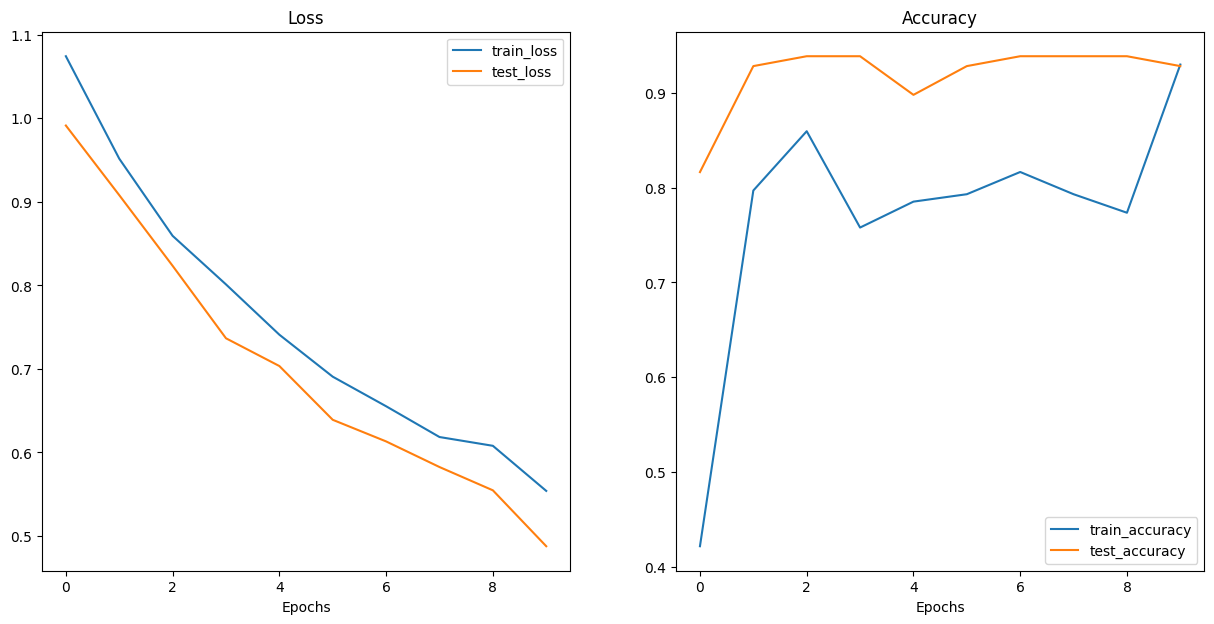

In [22]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f'[INFO] couldn"t find helper_functions.py, downloading........')
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of model
plot_loss_curves(results)

## 6. Make predictions on images from test set

In [23]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model
def pred_and_plot(model: torch.nn.Module,
                  image_path: str,
                  class_names: List[str],
                  image_size: Tuple[int, int] = (224, 224),
                  transform: torchvision.transforms = None,
                  device: torch.device = device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesnt exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])
  # Predict on image
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference_mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim = 0)

    # 7. Make a prediction on the transformed image by passing it to the model
    target_image_pred = model(transformed_image.to(device))

    # 8. Convert the models output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

    # 9. Converts the models pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    # 10. Plot image with predicted label and probability
    plt.figure(figsize = (6,6))
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
    plt.axis(False)

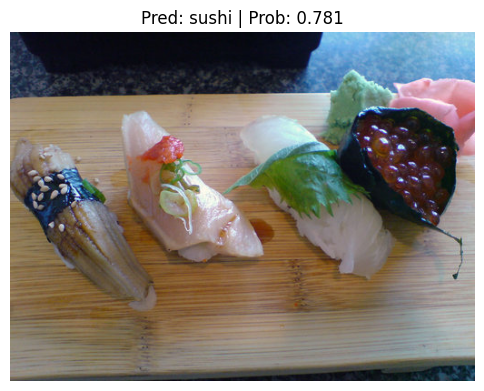

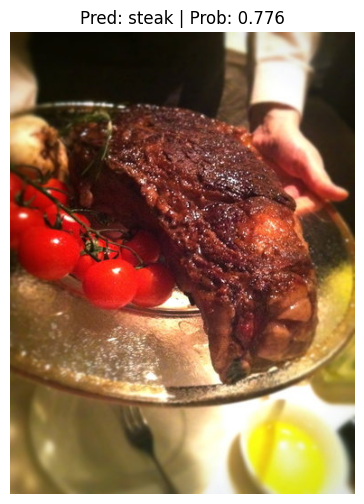

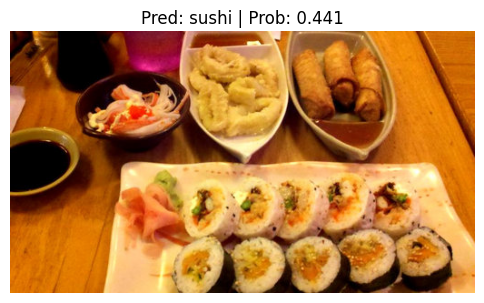

In [24]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population = test_image_path_list,
                                      k = num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot(model = model,
                      image_path = image_path,
                      class_names=class_names,
                      image_size = (224,224))

## Making predictions on custom image

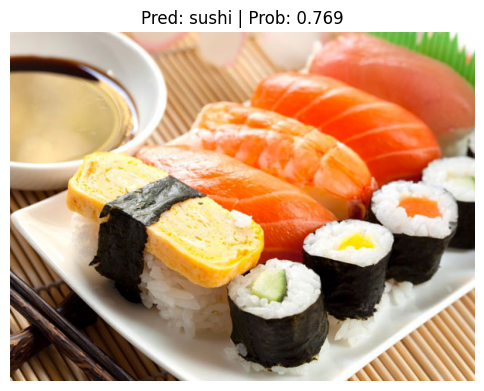

In [26]:
pred_and_plot(model = model,
              image_path = '/content/Sushi.jpg',
              class_names = class_names)